# Test and debug Kalman filter

---

## Equations verified by the simulator

$$
\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
- mg
+ mg \frac{\rho_w}{\rho_f}
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} - w \Big | \Big ( \frac{dz_f}{dt} - w \Big )
\end{align}
$$

## Equations employed by the Kalman filter

The Kalman state vector is:

$$
\begin{align*}
\underline{x} &= 
\left(\begin{array}{c} 
x_0\\
x_1\\
x_2\\
x_3
\end{array}\right)
=
\left(\begin{array}{c} 
-dz_f/dt\\
-z_f\\
\gamma_e \\
V_e \\
\end{array}\right)
\end{align*}
$$

Variables estimated by the Kalman filter are therefore the depth temporal rate of evolution ($x_0$, in m/s), depth ($x_1$, in m), equivalent compressibility ($\gamma_e$, in m$^2$) and the equivalent volume ($x_3$,  in m$^3$).

The Kalman filter dynamical equation is:

$$
\begin{align}
d\underline{x}/dt &= 
\left(\begin{array}{c} 
dx_0/dt\\
dx_1/dt\\
dx_2/dt\\
dx_3/dt
\end{array}\right)
=
\left(\begin{array}{c} 
-d^2z_f/dt^2\\
-dz_f/dt\\
0\\
0
\end{array}\right)
= 
\left(\begin{array}{c} 
-A (x_3 - x_2 x_1 +v) - B |x_0| x_0 \\
x_0\\
0 \\
0
\end{array}\right), \label{eq:dxdt}
\end{align}
$$

, where several parameters have been introduced: $A = g\rho/2m$ and $B = c_1/4L$.


which dimensionally is equivalent to:

\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
g \rho (V_e + \gamma_e z + v)
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \Big ( \frac{dz_f}{dt} \Big )
\end{align}

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from copy import deepcopy

import cognac.float as fl

---

## quick note on feedback

We choose the following relaxation function:

$$
\begin{align}
y = x_0 - \nu \arctan{\frac{\overline{x}_1-x_1}{\delta}},
\label{eq:y_0}
\end{align}
$$

where $\overline{x}_1$ is the target depth, $\nu_{reg} = \nu \pi/2$ is the typical vertical velocity the float should move at, and $\delta$ is a length scale that defines the zone of influence around the target depth. 

We are searching the command $u$ such that $y$ is the solution of:

$$
\begin{align}
\ddot y + \lambda_1 \dot y + \lambda_2 y = 0. \label{eq:y}
\end{align}
$$

For an exponential law of the type $y\sim e^{-r t}$ to be solution of the latter equations, we may choose: $\lambda_1=2r$, $\lambda_2=r^2$. 
For $r=0.1$~s$^{-1}$: $\lambda_1=0.2$~s$^{-1}$, $\lambda_2=0.01$~s$^{-2}$.

This choice of $y$ is such that when $t\xrightarrow{}\infty$: $x_0=\nu \arctan{\frac{\overline{x}_1-x_1}{\delta}}$.
This means that $x_0\xrightarrow{}0$ when $|x_1-\overline{x}_1|<\delta$. 
The float vertical velocity should also never be greater that $\pm \nu \times \pi/2$.


WOA water profile at lon=6, lat=40


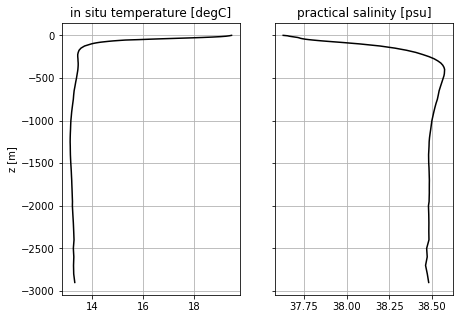

In [2]:
# select a water profile
#w = fl.waterp(lon=-50.,lat=40.) # Gulf Stream
w = fl.waterp(lon=6.,lat=40.) # Mediterranean sea
print(w)

--- 
## Instantiate the float object

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-500.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = fl.autonomous_float(model='Ifremer')
f.init_piston()
print(f)

# adjust mass to be at equilibrium at 0m and substract 5g
iz = np.argmin(np.abs(z+0))
f.adjust_m(p[iz],temp[iz],rho_w[iz], offset=-5)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

Piston max volume set from max displacement
Float parameters: 
  L     = 0.83 m      - float length
  r     = 0.07 m      - float radius
  m     = 11.63 kg     - float mass
  V     = 1.27e+04 cm^3   - float volume
  rho_cte = m/V = 9.13e+08 kg.cm^3   - float baseline density
  gamma = 3.78e-06 /dbar  - mechanical compressibility
  gamma x V = 4.82e-02 cm^3/dbar  - normalized compressibility
  alpha = 6.98e-05 /degC  - thermal compressibility
  alpha x V = 8.89e-01 cm^3/degC  - normalized thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 0.97 cm        - piston radius
  d     = 0.00 cm        - present piston displacement
  vol   = 26.88 cm^3      - present volume addition
  d_increment  = 8.57e-02 mm        - smallest variation of translation motion for the p

Piston reset for equilibrium : vol=2.2e+01 cm^3  
z equilibrium = -1.0m


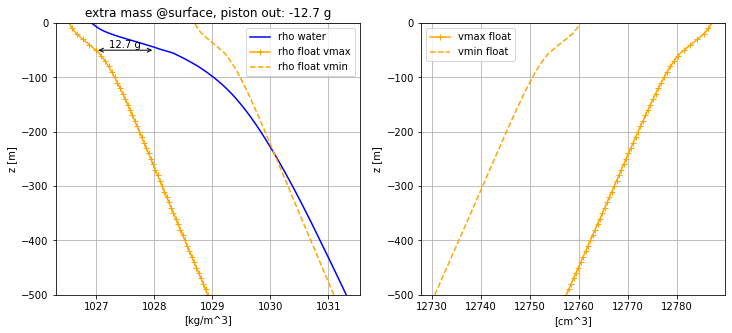

In [4]:
# adjust piston to be at equilibrium -1m
z0 = -1.
iz = np.argmin(np.abs(z-z0))
vstart = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) )

# show densities
fig, ax = plt.subplots(1, 2, figsize=(12,5))
fl.plot_float_density(z, f, w, ax=ax[0])
_ = fl.plot_float_volume(z, f, w, ax=ax[1])

In [5]:
# parameters used for kalman

delta_rho = 2 # [kg/m3] change of water density over the depth of interest 
L_rho = 100 # [m] characteristic length scale for water density changes
V_e_rho = -f.V*delta_rho/f.rho_cte # back of the envelope estimate for V_e
acceleration_rho = 0.5*fl.g*delta_rho/f.rho_cte

### equivalent volume and compressibilities

The float dynamics may be simplified and expressed as:

\begin{align}
2m\frac{d^2z_f}{dt^2}
+ m\frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \frac{dz_f}{dt} = 
g \rho (V_e + \gamma_e z + v),
\label{eq:zf_reg3}
\end{align}

where $V_e= V_0 [\delta\rho_w(\overline{z}) - \overline{z} \partial_z \rho_w ]/\rho$, $\gamma_e = V_0 \partial_z \rho_w /\rho + \gamma_V$, and, $\overline{z}$ is the averaged vertical level the float is moving around.


Back of the envelope estimate of V_e: -2.5e+01 cm^3


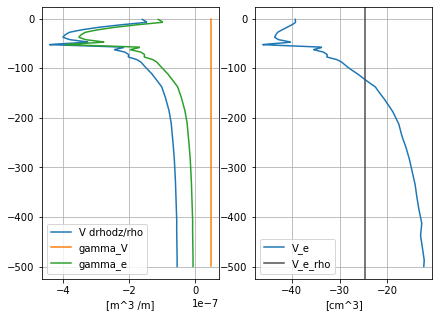

In [6]:
zm = (z[1:]+z[:-1])*.5

V_e = f.V*( (rho_w[:-1]+rho_w[1:])*.5 - f.rho_cte 
           - zm*np.diff(rho_w)/np.diff(z)
          )/f.rho_cte

gamma_V = f.V*f.gamma
gamma_rho = f.V*np.diff(rho_w)/f.rho_cte/np.diff(z)

gamma_e = gamma_rho + gamma_V

V_e100 = interp1d(zm, V_e, kind='linear')(-25)
gamma_e100 = interp1d(zm, gamma_e, kind='linear')(-25)

plt.figure(figsize=(7,5))
ax=plt.subplot(121)
ax.plot(gamma_rho, zm, label='V drhodz/rho')
ax.plot(gamma_V+0.*zm, zm, label='gamma_V')
ax.plot(gamma_e, zm, label='gamma_e')
ax.grid()
ax.legend(loc=3)
ax.set_xlabel('[m^3 /m]')

ax=plt.subplot(122)
ax.plot(V_e*1e6, zm, label='V_e')
ax.axvline(x=V_e_rho*1e6, color='0.3',label='V_e_rho')
ax.grid()
ax.legend()
ax.set_xlabel('[cm^3]')

print('Back of the envelope estimate of V_e: %.1e cm^3' %(V_e_rho*1e6))

---

### set up desired trajectory

In [7]:
# we start by constructing a trajectory that can be followed by the float
#target_velocity = 0.05
target_velocity = 10.
z_target = fl.descent(3600, -100., wmax=target_velocity, zstart=z0)

Tsim = 2700.

f0 = deepcopy(f)

---

### Kalman filter with exact dynamical system

The true dynamical equation is reset to that used by the Kalman and regulation:

\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
g \rho (V_e + \gamma_e z + v)
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \Big ( \frac{dz_f}{dt} \Big )
\end{align}

In [8]:
# use PID for control to decouple Kalman filtering from control
tau = 15. # time scale
u = f.piston.u_max/4.

_c = {'mode': 'pid', 'dt': 10.,
      'Kp': u, 'Ki': u/tau*0., 'Kd': u*tau*0., 
      'dz_nochattering': 0.}

In [9]:
V_e_cst = -4e-5
gamma_e_cst = -5*f.gammaV

def _compute_force(z, w, waterp, Lv, v=None, sum=False):
    g = 9.81
    f_b = g * f.rho_cte * (V_e_cst + gamma_e_cst * z + v)
    f_d = - f.m * f.c1/2/Lv * np.abs(w) * w
    if sum:
        return f_b+f_d
    else:
        return f_b+f_d, f_b, f_d
    
f.compute_force = _compute_force

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [-0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-01 1.00e-01 4.82e-08 4.00e-05]
  sqrt(gamma_alpha) / dt: [9.52e-03 4.76e-03 1.34e-11 1.11e-08]
  sqrt(gamma_beta): [3.16e-01]
Control parameters: 
  mode = pid 
  dt = 1.00e+01 
  dz_nochattering = 0.00e+00 
  Kp = 8.96e-06 
  Ki = 0.00e+00 
  Kd = 0.00e+00 
  continuous = 1.00e+00 

Start time stepping for 45 min ...
... time stepping done


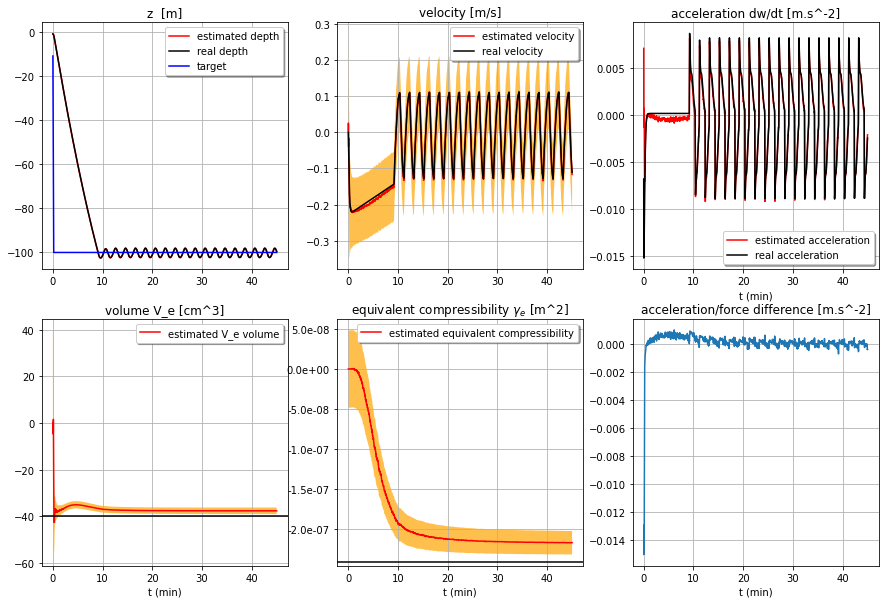

In [15]:
#expected_velocity = 0.1
#expected_acceleration = expected_velocity/tau*1e1 # value diagnosed a posteriori
expected_tau_Vgamma = 3600 # time scale used to scale V_e and gamma_e time rate of change

# general kalman filter parameters
_k = {'version': 'v0', 'dt':.5, 'depth_error': 1e-1}
# initial state vector
#_k.update({'gamma_e0': -2*f.gammaV, 'V_e0': 0.})
_k.update({'gamma_e0': .0, 'V_e0': 0.})
# initial state covariance:
_k.update({'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             V_e_cst,
                            ])**2})
# dynamics covariance:
_k.update({'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt'],
                                           f.gammaV/expected_tau_Vgamma,
                                           V_e_cst/expected_tau_Vgamma,
                                          ])**2 *1e0})
# observation error covariance:
_k.update({'gamma_beta': np.diag([_k['depth_error']**2 *1e1])})

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=vstart,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)
fl.plot_kalman_v0(f.log, f, V_e = V_e_cst, gamma_e = gamma_e_cst, z_target=z_target)
#f.plot_logs(z_target=z_target)

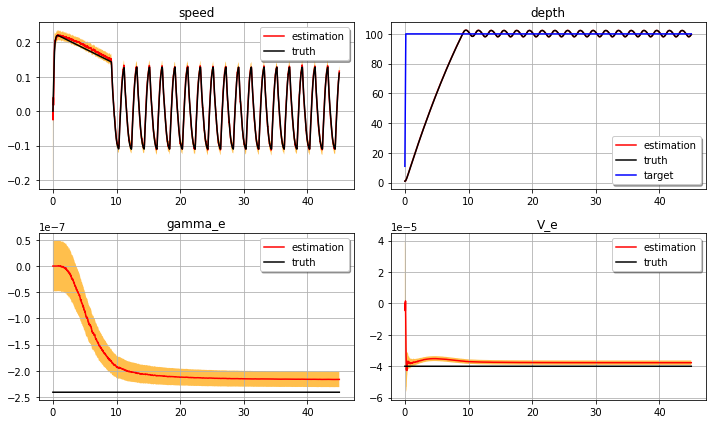

In [16]:
_t = -(f.log['state']._df
       .set_index('time')[['w','z']]
       .rename(columns={'w': 'x_0', 'z': 'x_1'})
      )
_t['x_2'] = gamma_e_cst + _t['x_0']*0.
_t['x_3'] = V_e_cst + _t['x_0']*0.

fl.plot_kalman(f.log, f, z_target=z_target, truth=_t)

Offset between estimate and true value is much reduced when depth is known with a 1 cm accuracy instead of 10cm.

---

### Kalman filter with real physics

In [17]:
f = deepcopy(f0)

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [-0.00e+00, 1.00e+00, -9.63e-08, 0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-02 1.00e-02 4.82e-08 2.47e-05]
  sqrt(gamma_alpha) / dt: [9.52e-03 4.76e-03 2.47e-08 2.47e-06]
  sqrt(gamma_beta): [1.00e-02]
Control parameters: 
  mode = pid 
  dt = 1.00e+01 
  dz_nochattering = 0.00e+00 
  Kp = 8.96e-06 
  Ki = 0.00e+00 
  Kd = 0.00e+00 
  continuous = 1.00e+00 

Start time stepping for 45 min ...
... time stepping done


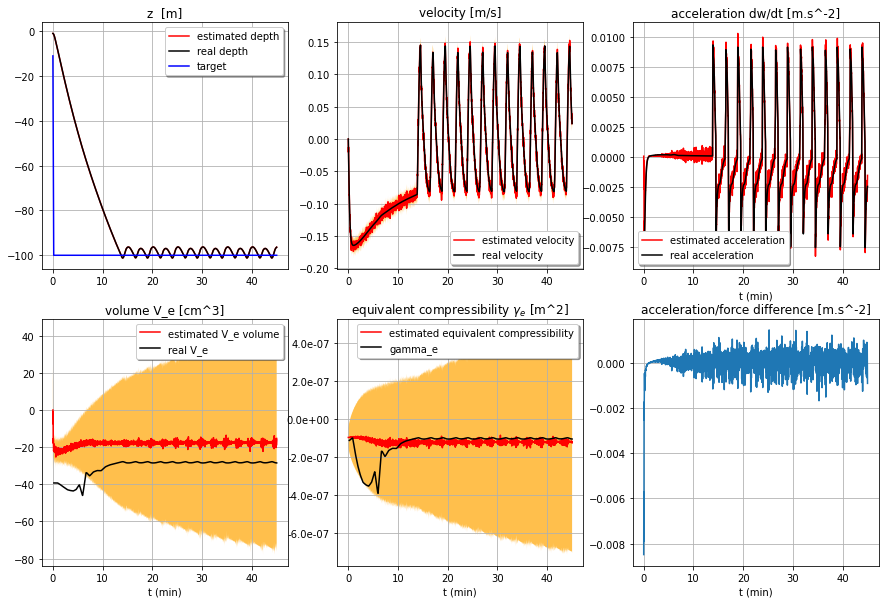

In [18]:
_k = {'dt':.5, 'depth_error': 1e-2}

# initial state vector
_k.update({'gamma_e0': -2*f.gammaV, 'V_e0': 0.,
          'gamma':np.array([_k['depth_error']/_k['dt'],
                            _k['depth_error'],
                            f.gammaV,
                            f.V*delta_rho/f.rho_cte,
                            ])**2,
          'gamma_alpha_scaled': np.array([acceleration_rho,
                                          acceleration_rho*_k['dt'],
                                          target_velocity*V_e_rho/L_rho**2,
                                          target_velocity*V_e_rho/L_rho,
                                          ])**2 *1e0})

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman_v0(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

In [19]:
print('acceleration_rho = %.1e m/s^2' %acceleration_rho)

acceleration_rho = 9.5e-03 m/s^2


The anticipated errors on acceleration (`acceleration_rho`) where about 0.01. They turned out to be of that order initialy but decreased down to 0.001 eventually (bottom-right figure).

Velocity error estimates decrease fairly rapidly to reach values around 2.1 cm/s: why this value?
The Kalman filter time step appears to have an impact on this value.

0    0.021103
1    0.018013
2    0.017999
3    0.016438
4    0.014277
Name: gamma_0, dtype: float64


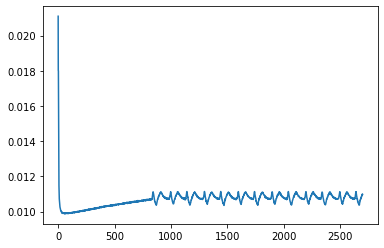

In [20]:
print(np.sqrt(f.log['kalman']._df['gamma_0']).head())
np.sqrt(f.log['kalman']._df['gamma_0']).plot()

---

### Kalman filter with feedback regulation

We start with a feedback with the true state. Note that physics is still the approximated one in the regulation though.

Decreasing `tau` (5s, we used 15s initially) leads to an improved match up with the target trajectory.
A value of 1 second leads to spurious oscillations when we want the float to stay at a constant depth though.

In [31]:
_k = {'dt':.5, 'depth_error': 1e-2}

_k.update({'gamma_e0': -2*f.gammaV, 'V_e0': 0.,
           'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte, # !!! x 10 !!!
                            ])**2 *1e2,
           'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt'],
                                           target_velocity*V_e_rho/L_rho**2,
                                           target_velocity*V_e_rho/L_rho,
                                           ])**2 *1e-1})

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,-9.63e-08,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-02 1.00e-02 4.82e-08 2.47e-05]
  sqrt(gamma_alpha) / dt: [9.52e-03 4.76e-03 1.24e-10 1.24e-08]
  sqrt(gamma_beta): [1.00e-02]
Control parameters: 
  mode = feedback2 
  dt = 5.00e+00 
  dz_nochattering = 0.00e+00 
  tau = 1.00e+01 
  nu = 6.37e-02 
  delta = 1.00e-01 
  continuous = 1.00e+00 

Start time stepping for 45 min ...
... time stepping done


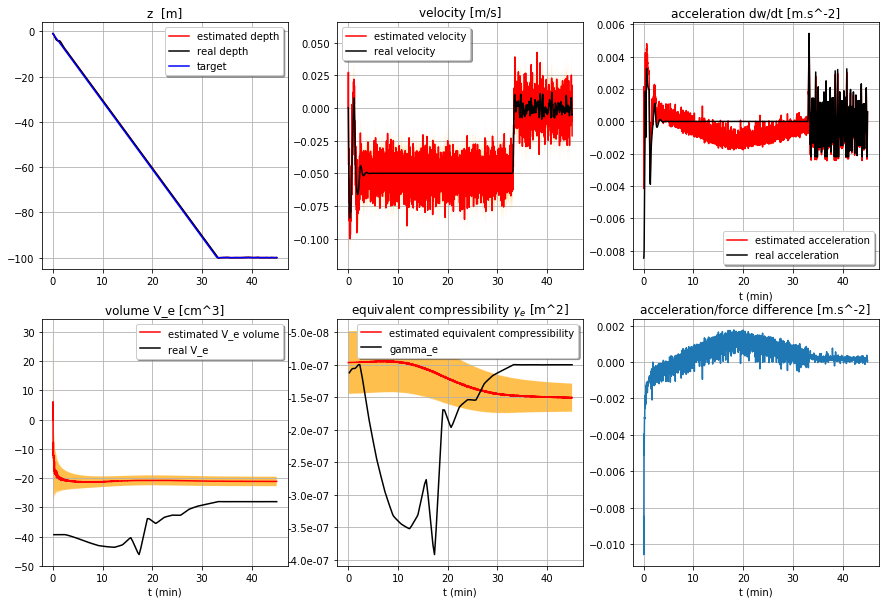

In [21]:
_c = {'mode': 'feedback2', 'dt': 5., 'dz_nochattering': 0.,
      'nu': 2*target_velocity*2./np.pi, 'tau': 10., 'delta': .1, 
     }

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

Extrapolated energy conssumption: 1.5e-01 Wh/day = 4.6 Wh/30day


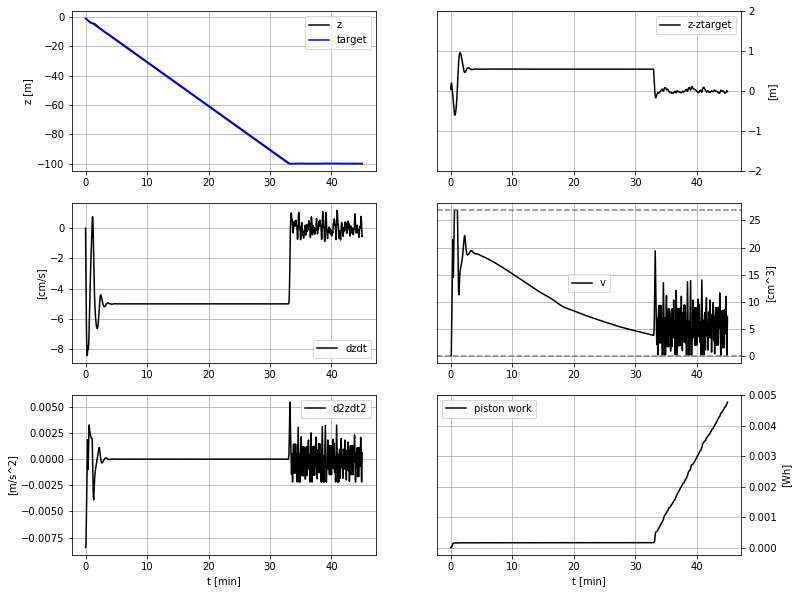

In [22]:
f.plot_logs(z_target=z_target)

We use now the kalman filter estimate for the regulation instead of the true state

In [44]:
w0 = deepcopy(w)

In [52]:
w0.SA

masked_array(data=[37.808779832707934, 37.83415010804143,
                   37.84437048331221, 37.86073305987252,
                   37.87733335661444, 37.893827930291835,
                   37.90275753213513, 37.90983398328668,
                   37.92245951581671, 37.937494532061464,
                   37.95784653430315, 37.98180030790119,
                   38.00801155961434, 38.03638829573491, 38.0673981118957,
                   38.09963819668158, 38.13288814558811,
                   38.16473917688973, 38.19476212468066,
                   38.22462042585909, 38.25558275201663,
                   38.37814951636421, 38.4653937709831, 38.53320873255315,
                   38.58684257206857, 38.6277899574632,
                   38.664959024972546, 38.69501502338185,
                   38.71687651485925, 38.734503037899565,
                   38.74589750343194, 38.7530459900981, 38.75680243417875,
                   38.7561465086124, 38.755375500371635,
                   38.75298703

In [53]:
w0.CT

masked_array(data=[19.37264013362107, 19.28543551559988,
                   19.156013153954696, 18.939937990016237,
                   18.619459615466848, 18.214569850038387,
                   17.723330722779014, 17.193350303335574,
                   16.663499678319603, 16.169766129641246,
                   15.738471649386856, 15.20771024199509,
                   14.958668368358765, 14.727258893345118,
                   14.54313741866563, 14.384584966100354,
                   14.235217110280349, 14.11866839698167,
                   14.019608025603505, 13.933527871842784,
                   13.863034939006774, 13.587862216459612,
                   13.442629643279856, 13.363058214469735,
                   13.325111474435092, 13.301577029788362,
                   13.297331862296014, 13.300688924939394,
                   13.299739440428317, 13.302187465598363,
                   13.298022424819585, 13.288867746505776,
                   13.278499557554746, 13.262782033204733,
  

In [54]:
w.CT[:], w.SA[:] = 18., 37.7

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,-9.63e-08,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-01 1.00e-01 4.82e-07 2.47e-04]
  sqrt(gamma_alpha) / dt: [9.52e-04 0.00e+00 2.47e-09 2.47e-07]
  sqrt(gamma_beta): [1.00e-02]
Control parameters: 
  mode = kalman_feedback2 
  dt = 1.00e+00 
  dz_nochattering = 0.00e+00 
  tau = 5.00e+00 
  nu = 3.18e-02 
  delta = 1.00e+00 
  continuous = 1.00e+00 

Start time stepping for 45 min ...
... time stepping done


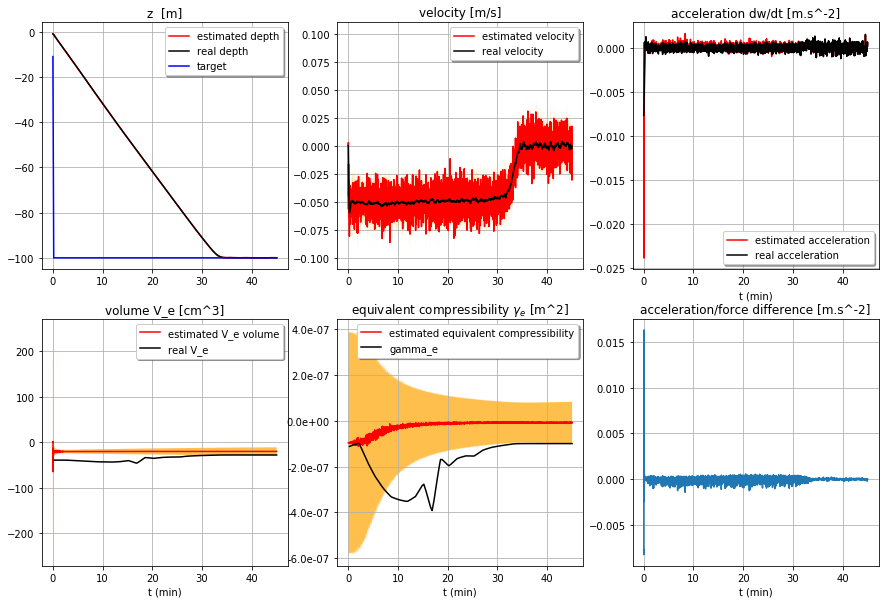

In [56]:
_k = {'dt':.5, 'depth_error': 1e-2}

_k.update({'gamma_e0': -2*f.gammaV, 'V_e0': 0.,
           'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte,
                            ])**2 *1e2,
           'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt']*0.,
                                           target_velocity*V_e_rho/L_rho**2,
                                           target_velocity*V_e_rho/L_rho,
                                           ])**2 *1e-2})
# alpha velocity = 1e-4
# alpha depth = 1e-5
# alpha offset (V_e) = 1e-8
# alpha chi (gamma_e) = 1e-8

_c = {'mode': 'kalman_feedback2', 'dt': 1., 'dz_nochattering': 0., # dt=5,
      'nu': .05*2./np.pi, 'tau': 5., 'delta': 1., 
     }
#      'nu': 2.*target_velocity*2./np.pi, 'tau': 10., 'delta': 1., 

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

Extrapolated energy conssumption: 1.4e-01 Wh/day = 4.3 Wh/30day


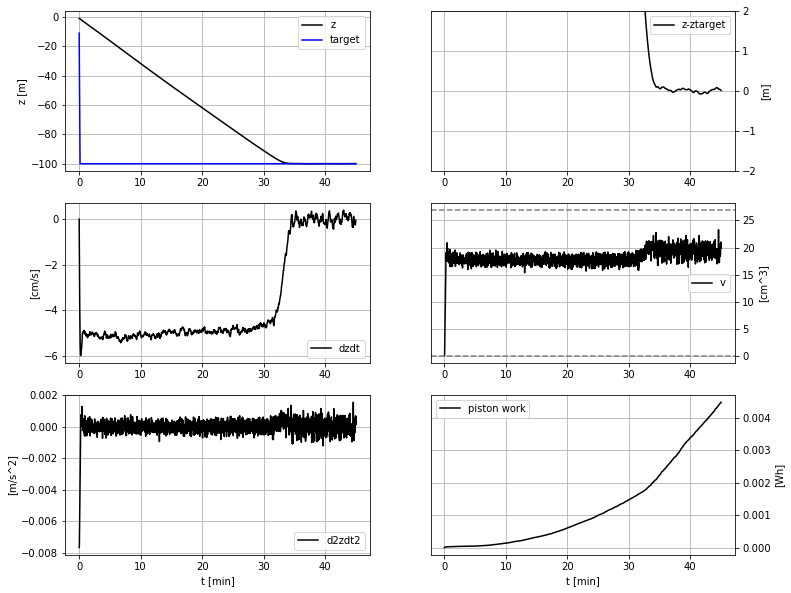

In [57]:
f.plot_logs(z_target=z_target)

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,-9.63e-08,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-01 1.00e-01 4.82e-07 2.47e-04]
  sqrt(gamma_alpha) / dt: [9.52e-04 0.00e+00 2.47e-09 2.47e-07]
  sqrt(gamma_beta): [1.00e-02]
Control parameters: 
  mode = kalman_feedback2 
  dt = 1.00e+00 
  dz_nochattering = 0.00e+00 
  tau = 5.00e+00 
  nu = 3.18e-02 
  delta = 1.00e+00 
  continuous = 1.00e+00 

Start time stepping for 45 min ...
... time stepping done


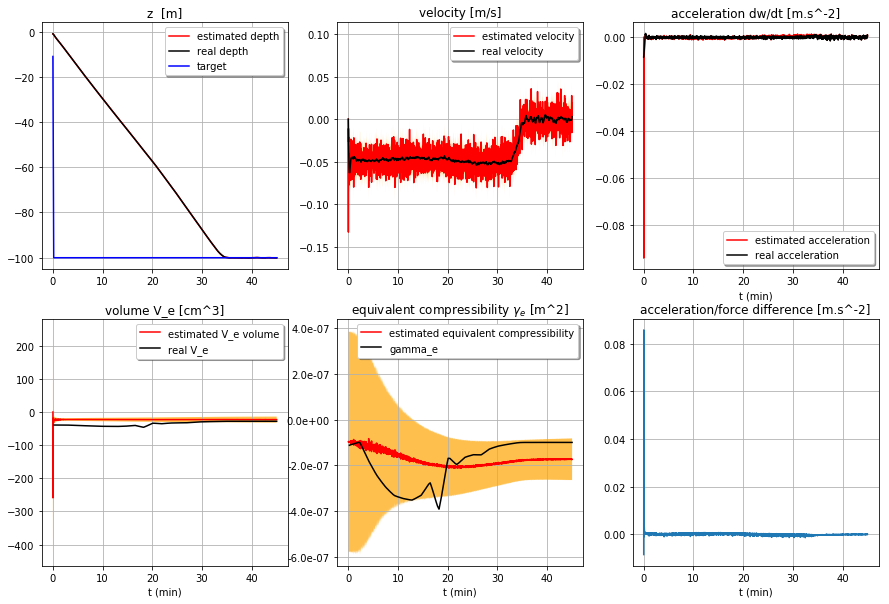

In [43]:
_k = {'dt':.5, 'depth_error': 1e-2}

_k.update({'gamma_e0': -2*f.gammaV, 'V_e0': 0.,
           'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte,
                            ])**2 *1e2,
           'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt']*0.,
                                           target_velocity*V_e_rho/L_rho**2,
                                           target_velocity*V_e_rho/L_rho,
                                           ])**2 *1e-2})
# alpha velocity = 1e-4
# alpha depth = 1e-5
# alpha offset (V_e) = 1e-8
# alpha chi (gamma_e) = 1e-8

_c = {'mode': 'kalman_feedback2', 'dt': 1., 'dz_nochattering': 0., # dt=5,
      'nu': .05*2./np.pi, 'tau': 5., 'delta': 1., 
     }
#      'nu': 2.*target_velocity*2./np.pi, 'tau': 10., 'delta': 1., 

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

Extrapolated energy conssumption: 1.3e-01 Wh/day = 4.0 Wh/30day


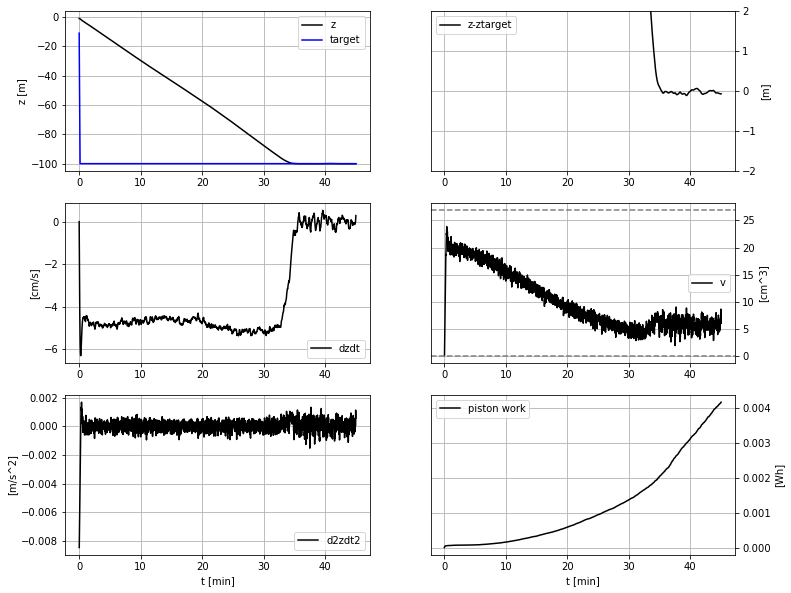

In [46]:
f.plot_logs(z_target=z_target)

In [ ]:
# pendant descente: bruit peut-être réglé par l'astuce avec l'interval de vitesse autour de nu
# au niveau du plateau, le bruit génère les fluctuations observées, améliorable avec le lissage des mesures de pression

In [24]:
f.log['dynamics'].plot_bk()

Loading BokehJS ...

We apply now piston ajustements discontinuously

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,-9.63e-08,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-02 1.00e-02 4.82e-08 2.47e-05]
  sqrt(gamma_alpha) / dt: [9.52e-03 4.76e-03 1.24e-10 1.24e-08]
  sqrt(gamma_beta): [1.00e-02]
Control parameters: 
  mode = kalman_feedback2 
  dt = 5.00e+00 
  dz_nochattering = 0.00e+00 
  tau = 1.00e+01 
  nu = 6.37e-02 
  delta = 1.00e-01 
  continuous = 0.00e+00 

Start time stepping for 45 min ...
... time stepping done


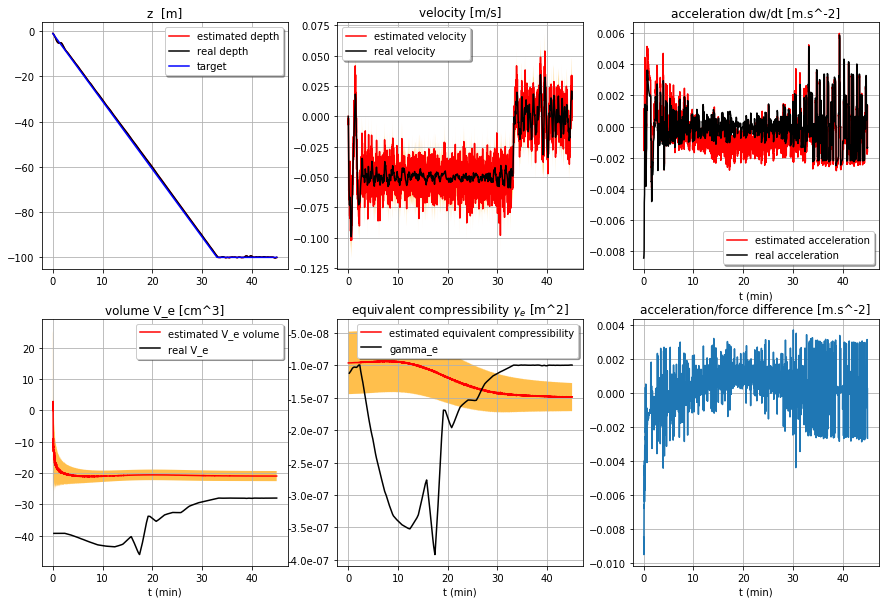

In [26]:
_c = {'mode': 'kalman_feedback2', 'dt': 5., 'dz_nochattering': 0.,
      'nu': 2*target_velocity*2./np.pi, 'tau': 10., 'delta': .1,
      'continuous': False,
     }

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

Extrapolated energy conssumption: 2.6e-01 Wh/day = 7.8 Wh/30day


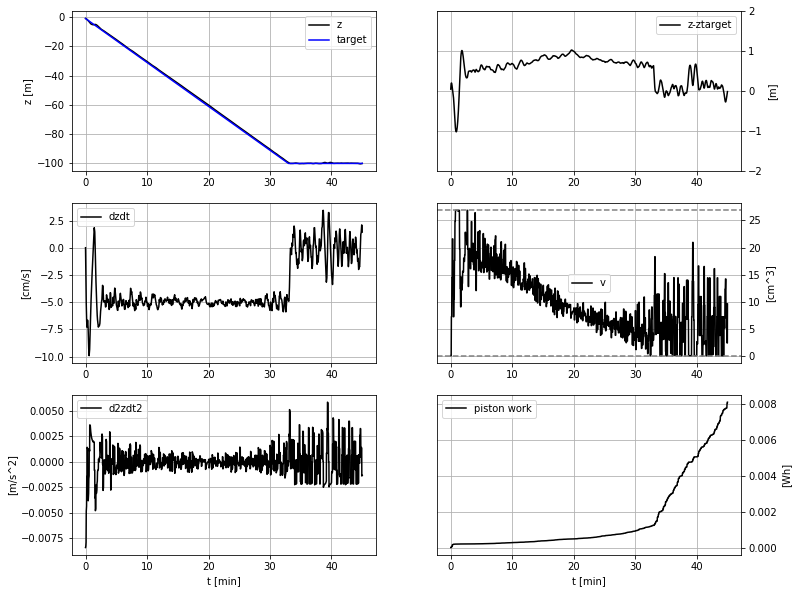

In [27]:
f.plot_logs(z_target=z_target)

### with reduced error on depth

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,-9.63e-08,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-03 1.00e-03 4.82e-08 2.47e-05]
  sqrt(gamma_alpha) / dt: [9.52e-03 4.76e-03 1.24e-10 1.24e-08]
  sqrt(gamma_beta): [1.00e-03]
Control parameters: 
  mode = kalman_feedback2 
  dt = 5.00e+00 
  dz_nochattering = 0.00e+00 
  tau = 1.00e+01 
  nu = 6.37e-02 
  delta = 1.00e-01 
  continuous = 0.00e+00 

Start time stepping for 45 min ...
... time stepping done


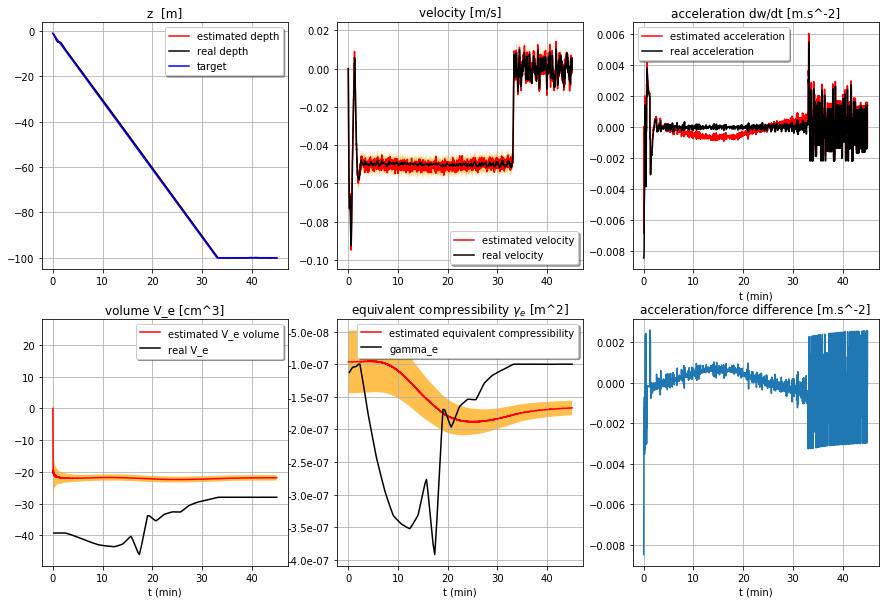

In [28]:
_k = {'dt':.5, 'depth_error': 1e-3}

_k.update({'gamma_e0': -2*f.gammaV, 'V_e0': 0.,
           'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte,
                            ])**2,
           'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt'],
                                           target_velocity*V_e_rho/L_rho**2,
                                           target_velocity*V_e_rho/L_rho,
                                           ])**2 *1e0})

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

Extrapolated energy conssumption: 4.1e+00 Wh/day = 123.3 Wh/30day


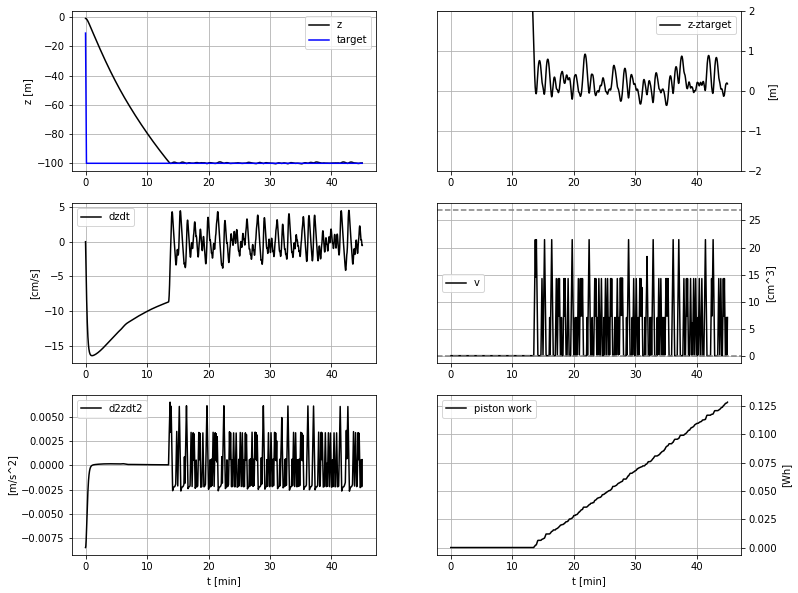

In [13]:
f.plot_logs(z_target=z_target)

---

### now increase time steps

Kalman filter: 
  dt     = 1.00 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,-9.63e-08,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [1.00e-02 1.00e-02 4.82e-08 2.47e-05]
  sqrt(gamma_alpha) / dt: [9.52e-03 9.52e-03 1.24e-10 1.24e-08]
  sqrt(gamma_beta): [1.00e-02]
Control parameters: 
  mode = kalman_feedback2 
  dt = 1.00e+01 
  dz_nochattering = 0.00e+00 
  tau = 2.00e+01 
  nu = 6.37e-02 
  delta = 1.00e+00 
  continuous = 0.00e+00 

Start time stepping for 45 min ...
... time stepping done


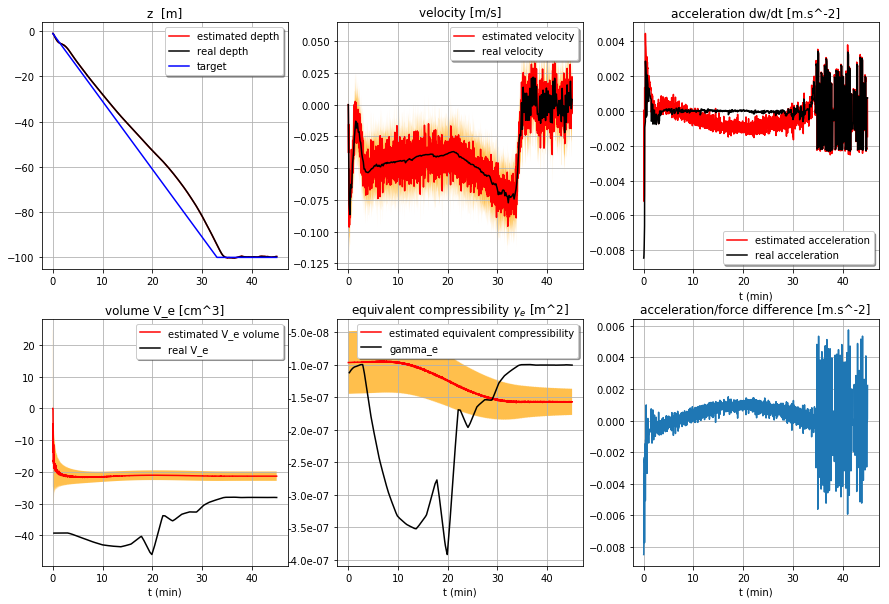

In [26]:
scale = 2.

_k = {'dt':0.5*scale, 'depth_error': 1e-2}

_k.update({'gamma_e0': -2*f.gammaV, 'V_e0': 0.,
           'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte,
                            ])**2,
           'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt'],
                                           target_velocity*V_e_rho/L_rho**2,
                                           target_velocity*V_e_rho/L_rho,
                                           ])**2 *1e0})

_c = {'mode': 'kalman_feedback2', 'dt': 5.*scale, 'dz_nochattering': 0.,
      'nu': 2*target_velocity*2./np.pi, 'tau': 10.*scale, 'delta': 1.,
      'continuous': False,
     }

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)

fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

Kalman filter: 
  dt     = 2.50 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,-9.63e-08,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [4.00e-03 1.00e-02 4.82e-08 2.47e-05]
  sqrt(gamma_alpha) / dt: [9.52e-03 2.38e-02 1.24e-10 1.24e-08]
  sqrt(gamma_beta): [1.00e-02]
Control parameters: 
  mode = kalman_feedback2 
  dt = 2.50e+01 
  dz_nochattering = 0.00e+00 
  tau = 5.00e+01 
  nu = 6.37e-02 
  delta = 1.00e+00 
  continuous = 0.00e+00 

Start time stepping for 45 min ...
... time stepping done


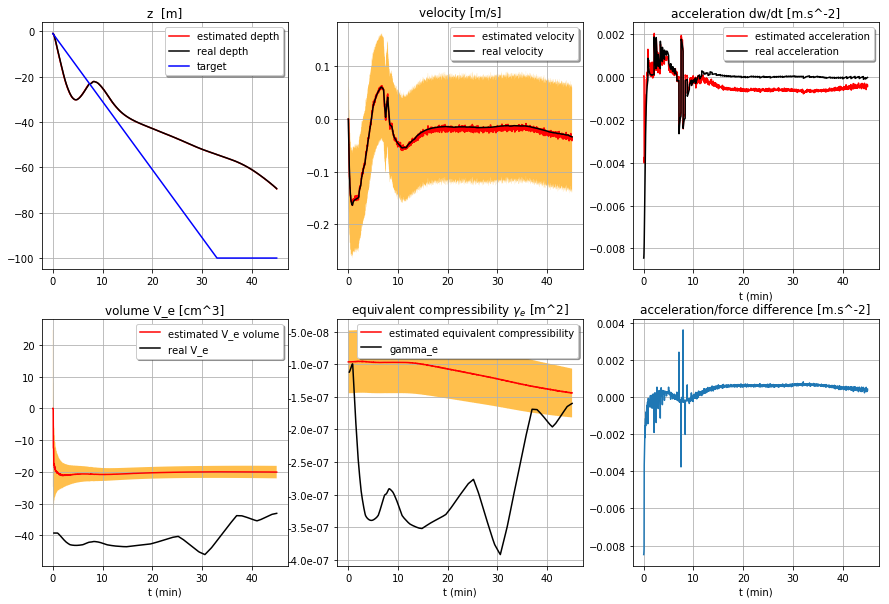

In [29]:
scale = 5.

_k = {'dt':0.5*scale, 'depth_error': 1e-2}

_k.update({'gamma_e0': -2*f.gammaV, 'V_e0': 0.,
           'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte,
                            ])**2,
           'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt'],
                                           target_velocity*V_e_rho/L_rho**2,
                                           target_velocity*V_e_rho/L_rho,
                                           ])**2 *1e0})

_c = {'mode': 'kalman_feedback2', 'dt': 5.*scale, 'dz_nochattering': 0.,
      'nu': 2*target_velocity*2./np.pi, 'tau': 10.*scale, 'delta': 1.,
      'continuous': False,
     }

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)

fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

In [19]:
print(f.kalman.A_coeff, f.kalman.B_coeff)

384.9174827133374 0.3020053152935492
